In [1]:
#Importing required libraries

import pandas as pd
import numpy as np
import re
import nltk
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import Conv1D
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers.recurrent import LSTM

### Importing and Analyzing the dataset

In [2]:
#Importing the csv file which IMDB dataset
movie_reviews = pd.read_csv('IMDB_Dataset.csv')

In [3]:
#Exploring the data
movie_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
movie_reviews.shape

(50000, 2)

__This dataset contains contains 2 columns with review and sentiment along with 50000 data points__ 

In [5]:
#Chacking if there are any null values in the dataset
movie_reviews.isnull().values.any()

False

In [6]:
#Observing a random review to check how the review is structured
movie_reviews['review'][3]

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

__By observing the review I feel there is a need to preprocess this text as it contains aspects which are not important for the analysis__

In [7]:
#Getting count for sentiment column 
movie_reviews['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

<AxesSubplot:xlabel='sentiment', ylabel='count'>

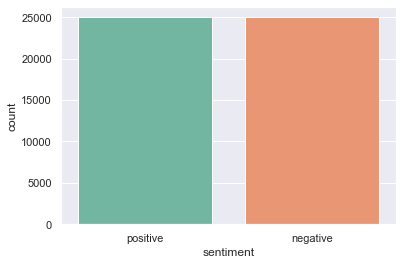

In [8]:
#Displaying value counts for sentiment column
import seaborn as sns
sns.set_theme(style='darkgrid')
sns.countplot(x='sentiment', data=movie_reviews, palette="Set2")

__There are equal amount of positive and negative in the dataset__

### Data Preprocessing

Steps to preprocess the text data
- Remove the html tags present
- Remove the punctuations and numbers in the text
- Remove multiple spaces
- Remove single characters present in the data

In [11]:
#Using regular expressions to remove unwanted data
def preprocess_text(text1):
    # Removing html tags
    sentence = remove_tags(text1)
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    
    return sentence

In [12]:
#Removing html tags (removes anything in the format <> with an empty space)
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [13]:
#Implementing the above definitiosn and appending the reviews present in an input array
input_ = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    input_.append(preprocess_text(sen))

In [14]:
#Viewing the preprocessed text
input_[1]

'A wonderful little production The filming technique is very unassuming very old time BBC fashion and gives comforting and sometimes discomforting sense of realism to the entire piece The actors are extremely well chosen Michael Sheen not only has got all the polari but he has all the voices down pat too You can truly see the seamless editing guided by the references to Williams diary entries not only is it well worth the watching but it is terrificly written and performed piece masterful production about one of the great master of comedy and his life The realism really comes home with the little things the fantasy of the guard which rather than use the traditional dream techniques remains solid then disappears It plays on our knowledge and our senses particularly with the scenes concerning Orton and Halliwell and the sets particularly of their flat with Halliwell murals decorating every surface are terribly well done '

In [15]:
#Converting the values in sentiment columns with 1 if positive and remaining 0 
output = movie_reviews['sentiment']

output = np.array(list(map(lambda x: 1 if x=="positive" else 0, output)))

In [16]:
#Splitting the data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(input_, output, test_size=0.20, random_state=42)

### Preparing the Embedding Layer

In [17]:
#Creating a word-to-index dictionary where each word in the corpus is used as a key and corresponding unique index is used as a value for the key
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train) #Updates internal vocabulary based on a list of texts

X_train = tokenizer.texts_to_sequences(X_train) #Transforms each text in texts to a sequence of integers
X_test = tokenizer.texts_to_sequences(X_test)

Now there will be 40000 lists in X_train where each list contains integers, each list corresponding to each sentence in training set

In [18]:
#Setting the maximum size of each list to 100, if the size of list is greater than 100 rest will be truncated and if size is less than 100 it adds 0
# Adding 1 because of reserved 0 index

vocab_size = len(tokenizer.word_index) + 1
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [19]:
#Using GloVe embeddings to create feature matrix
#Loading word embeddings and creating a dictionary that will contain words s keys and their corresponding embedding list as values
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [20]:
#Creating an embedding matrix where row number will correspond to index of the word in the corpus and contains GloVe word embeddings for the words in our corpus
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

Embedding matrix has been created 

### Text classification with Neural Networks

In [22]:
#Initialising the ANN 
#Sequential groups a linear stack of layers into a tf.keras.Model
model1 = Sequential()

In [23]:
#Adding the embedding layer
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model1.add(embedding_layer)

In [24]:
#Adding flatten layer
model1.add(Flatten())

In [25]:
#Adding the dense layer with sigmoid activation function
model1.add(Dense(1, activation='sigmoid'))

In [26]:
#Compiling the ANN
#For binary output loss will be binary_crossentropy and categorical_crossentropy for more classes 
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [27]:
print(model1.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          9254700   
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 10001     
Total params: 9,264,701
Trainable params: 10,001
Non-trainable params: 9,254,700
_________________________________________________________________
None


In [28]:
#Fitting ANN model with training data
ann_model = model1.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

Epoch 1/10
250/250 [==============================] - 2s 5ms/step - loss: 0.6629 - acc: 0.6124 - val_loss: 0.5553 - val_acc: 0.7151
Epoch 2/10
250/250 [==============================] - 1s 4ms/step - loss: 0.4966 - acc: 0.7605 - val_loss: 0.5177 - val_acc: 0.7436
Epoch 3/10
250/250 [==============================] - 1s 5ms/step - loss: 0.4566 - acc: 0.7880 - val_loss: 0.5227 - val_acc: 0.7425
Epoch 4/10
250/250 [==============================] - 1s 4ms/step - loss: 0.4249 - acc: 0.8081 - val_loss: 0.5217 - val_acc: 0.7424
Epoch 5/10
250/250 [==============================] - 1s 5ms/step - loss: 0.4095 - acc: 0.8167 - val_loss: 0.5376 - val_acc: 0.7377
Epoch 6/10
250/250 [==============================] - 1s 5ms/step - loss: 0.4003 - acc: 0.8214 - val_loss: 0.5413 - val_acc: 0.7380
Epoch 7/10
250/250 [==============================] - 2s 8ms/step - loss: 0.3905 - acc: 0.8287 - val_loss: 0.5360 - val_acc: 0.7435
Epoch 8/10
250/250 [==============================] - 2s 6ms/step - loss: 0.

In [29]:
score = model1.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 1s 2ms/step - loss: 0.6368 - acc: 0.7083


In [30]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.636848509311676
Test Accuracy: 0.708299994468689


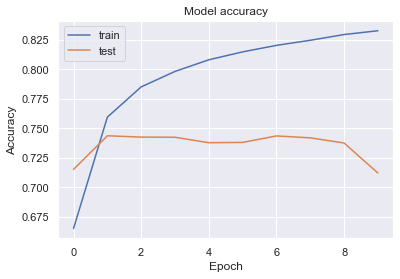

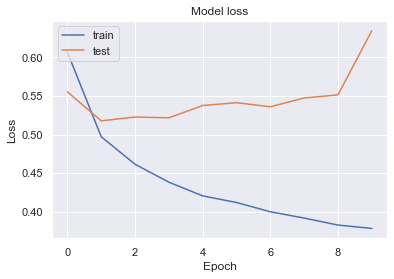

In [31]:
#Implementing accuracy and loss for train and test data
import matplotlib.pyplot as plt

plt.plot(ann_model.history['acc'])
plt.plot(ann_model.history['val_acc'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(ann_model.history['loss'])
plt.plot(ann_model.history['val_loss'])

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

The difference between the train and test is more and this clearly shows overfitting on training data.

__Convolutional neural network works well with image data which tries to find specific features in an image. CNNs have been found to work well with text data as well. Since text data is one dimensional we can use 1D convolutional neural network to extract features for our data__

### Implementing Convolutionsl Neural Network to classify text

In [32]:
#Initialising the CNN 
#Sequential groups a linear stack of layers into a tf.keras.Model
model2 = Sequential()

In [33]:
#Adding the embedding layer
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model2.add(embedding_layer)

In [34]:
#AAdding Conv1D layer
model2.add(Conv1D(128, 5, activation='relu'))

In [35]:
#Adding 1D max pooling layer
model2.add(GlobalMaxPooling1D())

In [36]:
#Adding dense layer with sigmoid acitivation function
model2.add(Dense(1, activation='sigmoid'))

In [37]:
#Compiling the CNN
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [38]:
print(model2.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          9254700   
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 9,318,957
Trainable params: 64,257
Non-trainable params: 9,254,700
_________________________________________________________________
None


In [39]:
#Fitting CNN with training data
cnn_model = model2.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 11s 43ms/step - loss: 0.5786 - acc: 0.6874 - val_loss: 0.3926 - val_acc: 0.8235
Epoch 2/6
250/250 [==============================] - 20s 79ms/step - loss: 0.3821 - acc: 0.8320 - val_loss: 0.3599 - val_acc: 0.8384
Epoch 3/6
250/250 [==============================] - 11s 45ms/step - loss: 0.3187 - acc: 0.8651 - val_loss: 0.3472 - val_acc: 0.8445
Epoch 4/6
250/250 [==============================] - 9s 36ms/step - loss: 0.2820 - acc: 0.8839 - val_loss: 0.3415 - val_acc: 0.8461
Epoch 5/6
250/250 [==============================] - 11s 42ms/step - loss: 0.2472 - acc: 0.9039 - val_loss: 0.3371 - val_acc: 0.8508
Epoch 6/6
250/250 [==============================] - 16s 64ms/step - loss: 0.2148 - acc: 0.9195 - val_loss: 0.3373 - val_acc: 0.8510


In [40]:
score = model2.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 3s 11ms/step - loss: 0.3381 - acc: 0.8504


In [41]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3380817770957947
Test Accuracy: 0.8503999710083008


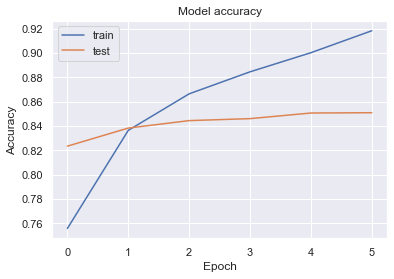

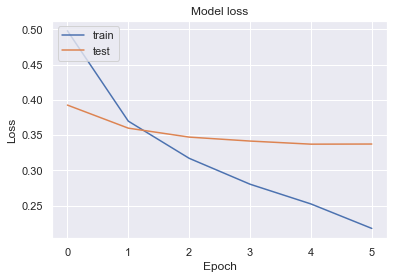

In [42]:
#Implementing plots for accuracy and loss 
import matplotlib.pyplot as plt

plt.plot(cnn_model.history['acc'])
plt.plot(cnn_model.history['val_acc'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(cnn_model.history['loss'])
plt.plot(cnn_model.history['val_loss'])

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

We can see that there is still difference between accuracy and loss between train and test data which depicts over fitting model with train data

So I'm trying with Recurrent Neural Network which is proven to work well with sequeunce data . Since text is actuallt a sequence of words, a RNN is an automatic choice to solve text related problems. I'm implementing LSTM (Long Short Term Memory Network) which is a vairant od RNN to solve sentiment classification problem

### Building a text classification model with Recurrent Neural Network

In [43]:
#Initialising the RNN 
#Sequential groups a linear stack of layers into a tf.keras.Model
model3 = Sequential()

In [44]:
#Adding embedding layer
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model3.add(embedding_layer)

In [45]:
#Adding LSTM layer with 128 neurons
model3.add(LSTM(128))

In [46]:
#Adding dense layer
model3.add(Dense(1, activation='sigmoid'))

In [47]:
#Compiling the RNN
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [48]:
print(model3.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          9254700   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 9,372,077
Trainable params: 117,377
Non-trainable params: 9,254,700
_________________________________________________________________
None


In [49]:
#Fitting RNN model with training data
rnn_model = model3.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 44s 156ms/step - loss: 0.6124 - acc: 0.6454 - val_loss: 0.4682 - val_acc: 0.7776
Epoch 2/6
250/250 [==============================] - 32s 130ms/step - loss: 0.4624 - acc: 0.7838 - val_loss: 0.4330 - val_acc: 0.7958
Epoch 3/6
250/250 [==============================] - 34s 134ms/step - loss: 0.4156 - acc: 0.8104 - val_loss: 0.3798 - val_acc: 0.8245
Epoch 4/6
250/250 [==============================] - 38s 151ms/step - loss: 0.3748 - acc: 0.8322 - val_loss: 0.3519 - val_acc: 0.8454
Epoch 5/6
250/250 [==============================] - 40s 157ms/step - loss: 0.3499 - acc: 0.8430 - val_loss: 0.3611 - val_acc: 0.8341
Epoch 6/6
250/250 [==============================] - 34s 137ms/step - loss: 0.3286 - acc: 0.8545 - val_loss: 0.3486 - val_acc: 0.8457


In [50]:
score = model3.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 11s 36ms/step - loss: 0.3520 - acc: 0.8442


In [51]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3520428240299225
Test Accuracy: 0.8442000150680542


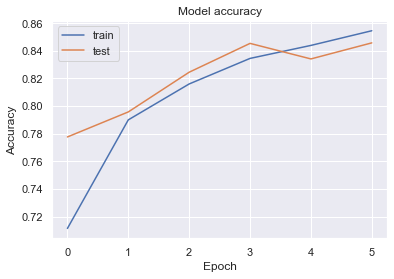

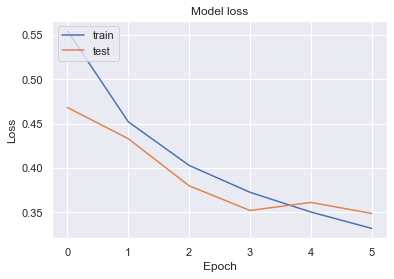

In [52]:
import matplotlib.pyplot as plt

plt.plot(rnn_model.history['acc'])
plt.plot(rnn_model.history['val_acc'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(rnn_model.history['loss'])
plt.plot(rnn_model.history['val_loss'])

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

It is clear from above plots that there is very less difference between accuracy, loss between train and test data. And accuracy for test data is 84.4% which is good

In [57]:
#Saving the RNN model to test with new data
model3.save('nlpModel')

INFO:tensorflow:Assets written to: nlpModel\assets


INFO:tensorflow:Assets written to: nlpModel\assets


In [58]:
#Dumping the tokenizer
import pickle
pickle.dump(tokenizer, open("token.pkl", "wb"))